In [ ]:
from google.colab import drive
# drive.mount("/content/drive", force_remount=True)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import gc
import numpy as np

# Paths for frames, masks, and model saving
FRAMES_PATH = "/content/drive/MyDrive/Monular3D/frames"
MASKS_PATH = "/content/drive/MyDrive/Monular3D/lane-masks"
MODEL_SAVE_PATH = "/content/drive/MyDrive/Monular3D/lane_detection_model.pth"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset class
class LaneDataset(Dataset):
    def __init__(self, frames_dir, masks_dir, transform=None, mask_transform=None):
        self.frames = sorted(os.listdir(frames_dir))
        self.masks = sorted(os.listdir(masks_dir))
        self.frames_dir = frames_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame_path = os.path.join(self.frames_dir, self.frames[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        frame = Image.open(frame_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            frame = self.transform(frame)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return frame, mask

# Transformations
frame_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Match decoder output
    transforms.ToTensor()
])

# Dataset and DataLoader
BATCH_SIZE = 4
dataset = LaneDataset(FRAMES_PATH, MASKS_PATH, transform=frame_transform, mask_transform=mask_transform)

VAL_SPLIT = 0.2
val_size = int(len(dataset) * VAL_SPLIT)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Model Components
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        resnet = models.resnet50(weights="IMAGENET1K_V1")
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

    def forward(self, x):
        return self.backbone(x)

class MaskDecoder(nn.Module):
    def __init__(self, input_channels):
        super(MaskDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(input_channels, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(256, 1, kernel_size=1)
        )

    def forward(self, x):
        return self.decoder(x)

class CameraPoseRegressor(nn.Module):
    def __init__(self, input_channels, hidden_dim=256):
        super(CameraPoseRegressor, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_channels * 8 * 8, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, x):
        return self.fc(x)

class LaneRegressor(nn.Module):
    def __init__(self, input_channels, hidden_dim=128):
        super(LaneRegressor, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_channels * 8 * 8, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, x):
        return self.fc(x)

class LaneDetectionModel(nn.Module):
    def __init__(self):
        super(LaneDetectionModel, self).__init__()
        self.encoder = ImageEncoder()
        self.mask_decoder = MaskDecoder(input_channels=2048)
        self.camera_pose_regressor = CameraPoseRegressor(input_channels=2048)
        self.lane_regressor = LaneRegressor(input_channels=2048)

    def forward(self, x):
        features = self.encoder(x)
        lane_mask = self.mask_decoder(features)
        theta = self.camera_pose_regressor(features)
        lane_anchors = self.lane_regressor(features)
        return lane_mask, lane_anchors, theta

# Model, Loss, Optimizer, Scheduler
model = LaneDetectionModel().to(DEVICE)

# Loss Functions
mask_criterion = nn.BCEWithLogitsLoss()
camera_pose_criterion = nn.MSELoss()
lane_regressor_criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

scaler = GradScaler()

# Training Loop with Post-Processing and Fine-Tuning

def post_process_predictions(pred_mask):
    """ Apply geometric constraints or refine lane mask prediction """
    return torch.sigmoid(pred_mask) > 0.5  # Example: Binary thresholding

def train_model(model, train_loader, val_loader, mask_criterion, camera_pose_criterion, lane_regressor_criterion, optimizer, scheduler, epochs=10):
    best_val_loss = float('inf')
    best_model_state = None
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0

        for batch_idx, (frames, masks) in enumerate(train_loader):
            frames = frames.to(DEVICE, non_blocking=True)
            masks = masks.to(DEVICE, non_blocking=True)

            with autocast():
                lane_mask, lane_anchors, theta = model(frames)

                # Compute individual losses
                mask_loss = mask_criterion(lane_mask, masks)
                pose_loss = camera_pose_criterion(theta, torch.zeros_like(theta).to(DEVICE))  # Example target
                lane_loss = lane_regressor_criterion(lane_anchors, torch.zeros_like(lane_anchors).to(DEVICE))

                loss = mask_loss + pose_loss + lane_loss

            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for frames, masks in val_loader:
                frames = frames.to(DEVICE, non_blocking=True)
                masks = masks.to(DEVICE, non_blocking=True)

                lane_mask, lane_anchors, theta = model(frames)

                # Compute individual losses
                mask_loss = mask_criterion(lane_mask, masks)
                pose_loss = camera_pose_criterion(theta, torch.zeros_like(theta).to(DEVICE))
                lane_loss = lane_regressor_criterion(lane_anchors, torch.zeros_like(lane_anchors).to(DEVICE))

                loss = mask_loss + pose_loss + lane_loss
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()

        scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}]:")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 50)

    # Restore best model
    model.load_state_dict(best_model_state)
    return model, history

# Incorporate Geometric Constraints
def apply_geometric_constraints(lane_mask):
    """
    Apply geometric constraints to refine lane mask predictions.

    Parameters:
    lane_mask (torch.Tensor): The predicted lane mask from the model.

    Returns:
    torch.Tensor: The refined lane mask after applying geometric constraints.
    """
    # Convert tensor to numpy for OpenCV processing
    lane_mask_np = lane_mask.cpu().numpy()

    # Placeholder perspective transformation matrix (example, modify as needed)
    M = np.float32([[1, 0, 0], [0, 1, 0], [0, 0, 1]])  # Identity matrix for no transformation

    # Apply the transformation to refine lane mask
    refined_lane_mask_np = cv2.warpPerspective(lane_mask_np, M, (lane_mask.shape[-1], lane_mask.shape[-2]))

    # Convert back to tensor and return
    refined_lane_mask = torch.tensor(refined_lane_mask_np, dtype=torch.float32).to(lane_mask.device)
    return refined_lane_mask

# Memory management utilities
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

# Execute training
trained_model, training_history = train_model(
    model, train_loader, val_loader, mask_criterion, camera_pose_criterion, lane_regressor_criterion,
    optimizer, scheduler, epochs=10)

# Save the final model
torch.save(trained_model.state_dict(), MODEL_SAVE_PATH)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]
<ipython-input-2-093d2ad97763>:153: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-2-093d2ad97763>:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocas

Epoch [1/10]:
Train Loss: 0.1608
Val Loss: 0.1378
Learning Rate: 0.000010
--------------------------------------------------
Epoch [2/10]:
Train Loss: 0.1325
Val Loss: 0.1243
Learning Rate: 0.000010
--------------------------------------------------
Epoch [3/10]:
Train Loss: 0.1215
Val Loss: 0.1159
Learning Rate: 0.000010
--------------------------------------------------
Epoch [4/10]:
Train Loss: 0.1133
Val Loss: 0.1090
Learning Rate: 0.000010
--------------------------------------------------
Epoch [5/10]:
Train Loss: 0.1078
Val Loss: 0.1057
Learning Rate: 0.000010
--------------------------------------------------
Epoch [6/10]:
Train Loss: 0.1034
Val Loss: 0.1023
Learning Rate: 0.000010
--------------------------------------------------
Epoch [7/10]:
Train Loss: 0.1004
Val Loss: 0.1006
Learning Rate: 0.000010
--------------------------------------------------
Epoch [8/10]:
Train Loss: 0.0979
Val Loss: 0.0988
Learning Rate: 0.000010
--------------------------------------------------


In [ ]:
from sklearn.metrics import jaccard_score, f1_score
import torch

def evaluate_model(model, val_loader, device=DEVICE):
    model.eval()  # Set the model to evaluation mode

    # Metrics
    pixel_accuracy = 0
    mean_iou = 0
    f1_score_total = 0
    num_samples = 0

    with torch.no_grad():
        for frames, masks in val_loader:
            frames = frames.to(device)
            masks = masks.to(device)

            # Forward pass
            lane_mask, _, _ = model(frames)

            # Convert the predictions and masks to binary values (0 or 1)
            pred_mask = torch.sigmoid(lane_mask) > 0.5  # Apply threshold for binary mask
            true_mask = masks > 0.5  # True mask for comparison

            # Pixel accuracy: count correct pixels divided by total pixels
            pixel_accuracy += (pred_mask == true_mask).sum().item() / pred_mask.numel()

            # Flatten the tensors to compute IoU and F1-score over all pixels
            pred_mask_flat = pred_mask.view(-1).cpu().numpy()
            true_mask_flat = true_mask.view(-1).cpu().numpy()

            # Compute IoU per sample in the batch
            iou = jaccard_score(true_mask_flat, pred_mask_flat, average='binary')
            mean_iou += iou

            # Compute F1-score per sample in the batch
            f1 = f1_score(true_mask_flat, pred_mask_flat, average='binary')
            f1_score_total += f1

            num_samples += 1

    # Average metrics over all samples
    pixel_accuracy /= num_samples
    mean_iou /= num_samples
    f1_score_avg = f1_score_total / num_samples

    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"F1 Score: {f1_score_avg:.4f}")
    return pixel_accuracy, mean_iou, f1_score_avg

def evaluate_pose_and_anchors(model, val_loader, device=DEVICE):
    model.eval()  # Set the model to evaluation mode

    # Metrics
    camera_pose_mae = 0
    lane_anchors_mae = 0
    num_samples = 0

    with torch.no_grad():
        for frames, masks in val_loader:
            frames = frames.to(device)
            masks = masks.to(device)

            # Forward pass
            lane_mask, lane_anchors, theta = model(frames)

            # Assign true_theta from the ground truth (masks) before using it
            true_theta = masks  # Assuming this is the ground truth for the camera pose
            true_anchors = masks  # Assuming this is the ground truth for lane anchors

            # Flatten the tensor if necessary (for camera pose comparison)
            true_theta = true_theta.view(true_theta.size(0), -1)  # Flatten spatial dimensions
            theta = theta.view(theta.size(0), -1)  # Flatten model output to match

            # Ensure both tensors are in the same shape for MAE calculation
            if true_theta.size(1) != 3:  # Check if true_theta has the wrong shape
                true_theta = true_theta[:, :3]  # Take the first 3 elements (camera pose)

            # Calculate MAE for camera pose (theta)
            camera_pose_mae += torch.abs(theta - true_theta).mean().item()

            # Reshape or pool the true_anchors to match the lane_anchors shape (batch_size, 3)
            true_anchors = true_anchors.view(true_anchors.size(0), -1)  # Flatten spatial dims
            true_anchors = true_anchors[:, :3]  # Take the first 3 elements if necessary

            # Calculate MAE for lane anchors
            lane_anchors_mae += torch.abs(lane_anchors - true_anchors).mean().item()

            num_samples += 1

    # Average metrics over all samples
    camera_pose_mae /= num_samples
    lane_anchors_mae /= num_samples

    print(f"Camera Pose MAE: {camera_pose_mae:.4f}")
    print(f"Lane Anchors MAE: {lane_anchors_mae:.4f}")
    return camera_pose_mae, lane_anchors_mae

def evaluate(model, val_loader, device=DEVICE):
    print("Evaluating lane mask prediction...")
    pixel_accuracy, mean_iou, f1_score_avg = evaluate_model(model, val_loader, device)

    print("Evaluating camera pose and lane anchors...")
    camera_pose_mae, lane_anchors_mae = evaluate_pose_and_anchors(model, val_loader, device)

    # Return all metrics
    return {
        "pixel_accuracy": pixel_accuracy,
        "mean_iou": mean_iou,
        "f1_score": f1_score_avg,
        "camera_pose_mae": camera_pose_mae,
        "lane_anchors_mae": lane_anchors_mae
    }

# Example usage
metrics = evaluate(model, val_loader)
print(metrics)

Evaluating lane mask prediction...
Pixel Accuracy: 0.9853
Mean IoU: 0.1327
F1 Score: 0.2259
Evaluating camera pose and lane anchors...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Camera Pose MAE: 0.0023
Lane Anchors MAE: 0.0046
{'pixel_accuracy': 0.9852979052197802, 'mean_iou': 0.13269425326470805, 'f1_score': 0.2259033760636942, 'camera_pose_mae': 0.0022692221234767483, 'lane_anchors_mae': 0.0045643317005290025}


In [ ]:
import torch

# Define the model save path
MODEL_SAVE_PATH = "reconstruction_of_3d_lane_model_weights.pth"

# Save only the model's weights
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model weights saved to {MODEL_SAVE_PATH}")

# Save the full model (architecture + weights)
FULL_MODEL_SAVE_PATH = "reconstruction_of_3d_lane_full_model.pth"
torch.save(model, FULL_MODEL_SAVE_PATH)
print(f"Full model saved to {FULL_MODEL_SAVE_PATH}")


Model weights saved to reconstruction_of_3d_lane_model_weights.pth
Full model saved to reconstruction_of_3d_lane_full_model.pth


# **Visualization**

In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch import ToTensorV2


FRAMES_PATH = "/content/drive/MyDrive/Monular3D/frames"
MASKS_PATH = "/content/drive/MyDrive/Monular3D/lane-masks"


# Dataset class
class LaneDataset(Dataset):
    def __init__(self, frames_dir, masks_dir, transform=None, mask_transform=None):
        self.frames = sorted(os.listdir(frames_dir))
        self.masks = sorted(os.listdir(masks_dir))
        self.frames_dir = frames_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame_path = os.path.join(self.frames_dir, self.frames[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        frame = Image.open(frame_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            frame = self.transform(frame)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return frame, mask

# Transformations
frame_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Match decoder output
    transforms.ToTensor()
])

# Dataset and DataLoader
BATCH_SIZE = 4
dataset = LaneDataset(FRAMES_PATH, MASKS_PATH, transform=frame_transform, mask_transform=mask_transform)

VAL_SPLIT = 0.2
val_size = int(len(dataset) * VAL_SPLIT)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Model Components
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # Use pretrained weights directly
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Remove the final layer and pool layer

    def forward(self, x):
        return self.backbone(x)

class MaskDecoder(nn.Module):
    def __init__(self, input_channels):
        super(MaskDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(input_channels, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(256, 1, kernel_size=1)
        )

    def forward(self, x):
        return self.decoder(x)

class CameraPoseRegressor(nn.Module):
    def __init__(self, input_channels, hidden_dim=256):
        super(CameraPoseRegressor, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_channels * 8 * 8, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, x):
        return self.fc(x)

class LaneRegressor(nn.Module):
    def __init__(self, input_channels, hidden_dim=128):
        super(LaneRegressor, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_channels * 8 * 8, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, x):
        return self.fc(x)

class LaneDetectionModel(nn.Module):
    def __init__(self):
        super(LaneDetectionModel, self).__init__()
        self.encoder = ImageEncoder()
        self.mask_decoder = MaskDecoder(input_channels=2048)
        self.camera_pose_regressor = CameraPoseRegressor(input_channels=2048)
        self.lane_regressor = LaneRegressor(input_channels=2048)

    def forward(self, x):
        features = self.encoder(x)
        lane_mask = self.mask_decoder(features)
        theta = self.camera_pose_regressor(features)
        lane_anchors = self.lane_regressor(features)
        return lane_mask, lane_anchors, theta

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LaneDetectionModel().to(device)
model_path = '/content/drive/MyDrive/Monular3D/reconstruction_of_3d_lane_model_weights.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]
<ipython-input-2-c894fa0338ae>:145: Futu

LaneDetectionModel(
  (encoder): ImageEncoder(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace

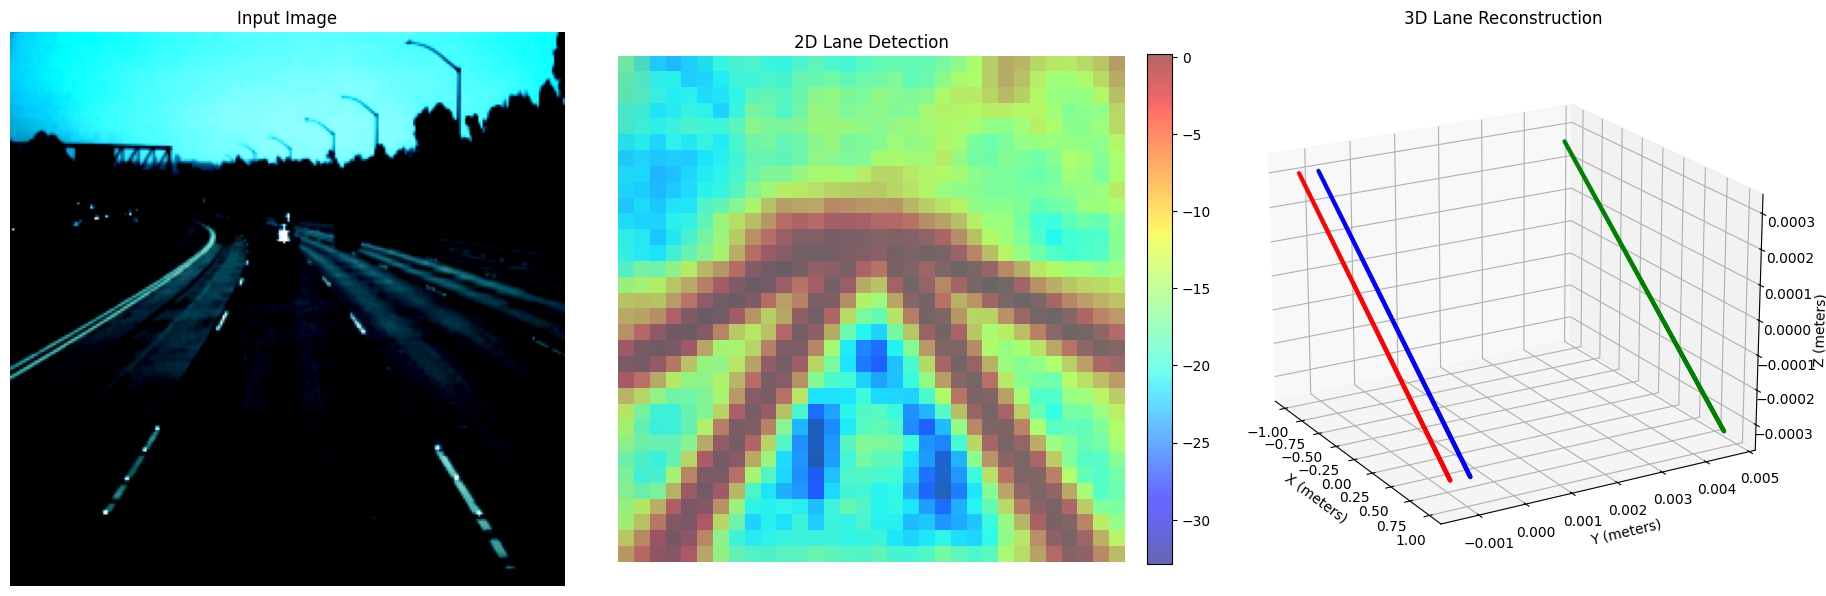

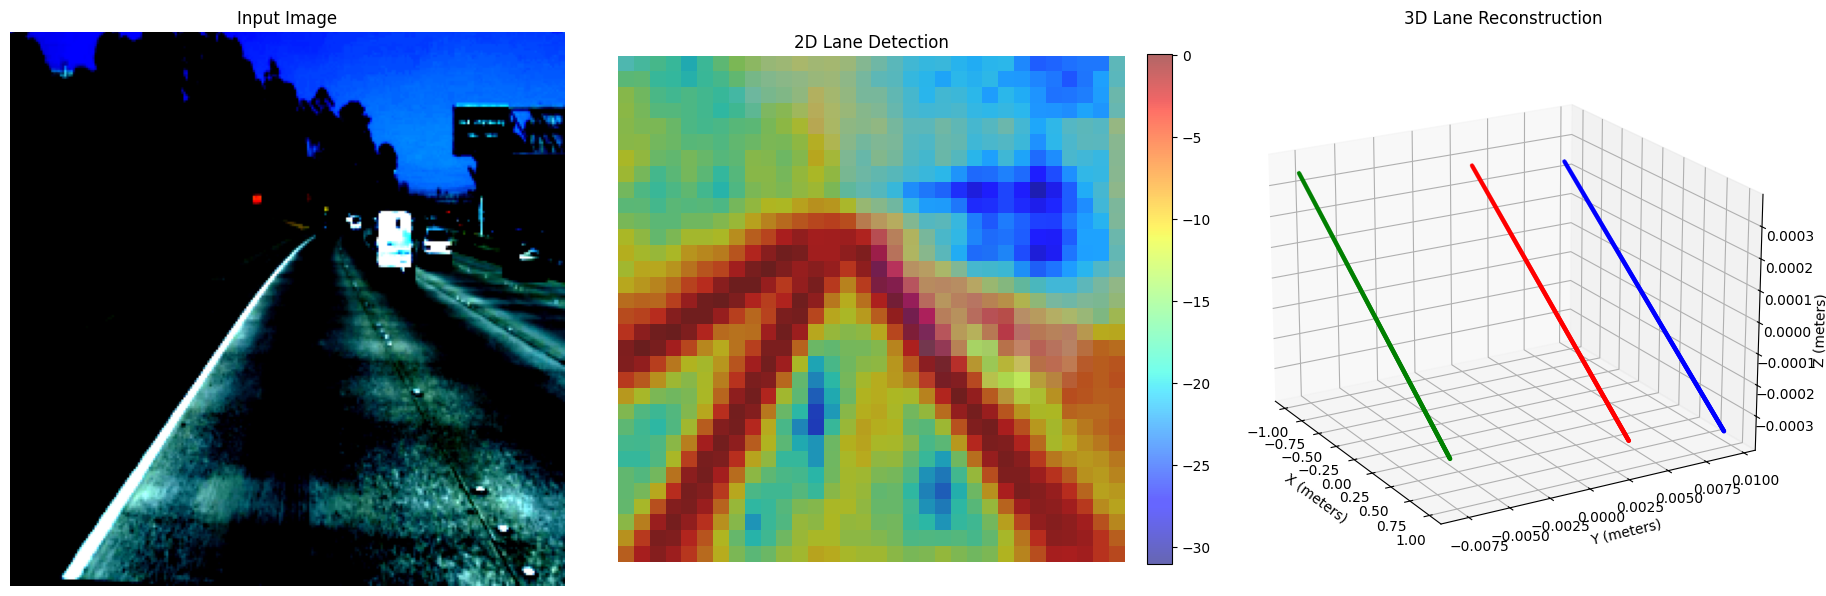

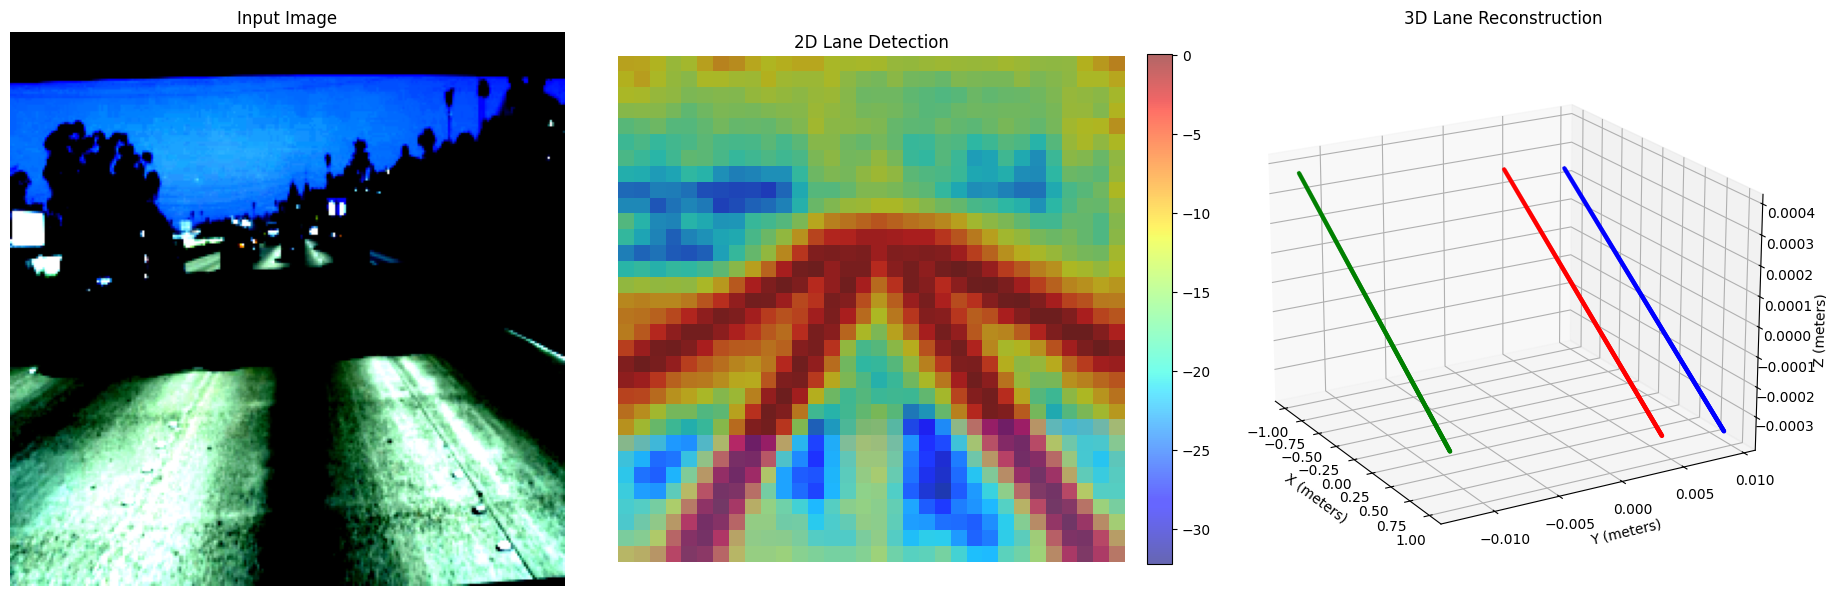

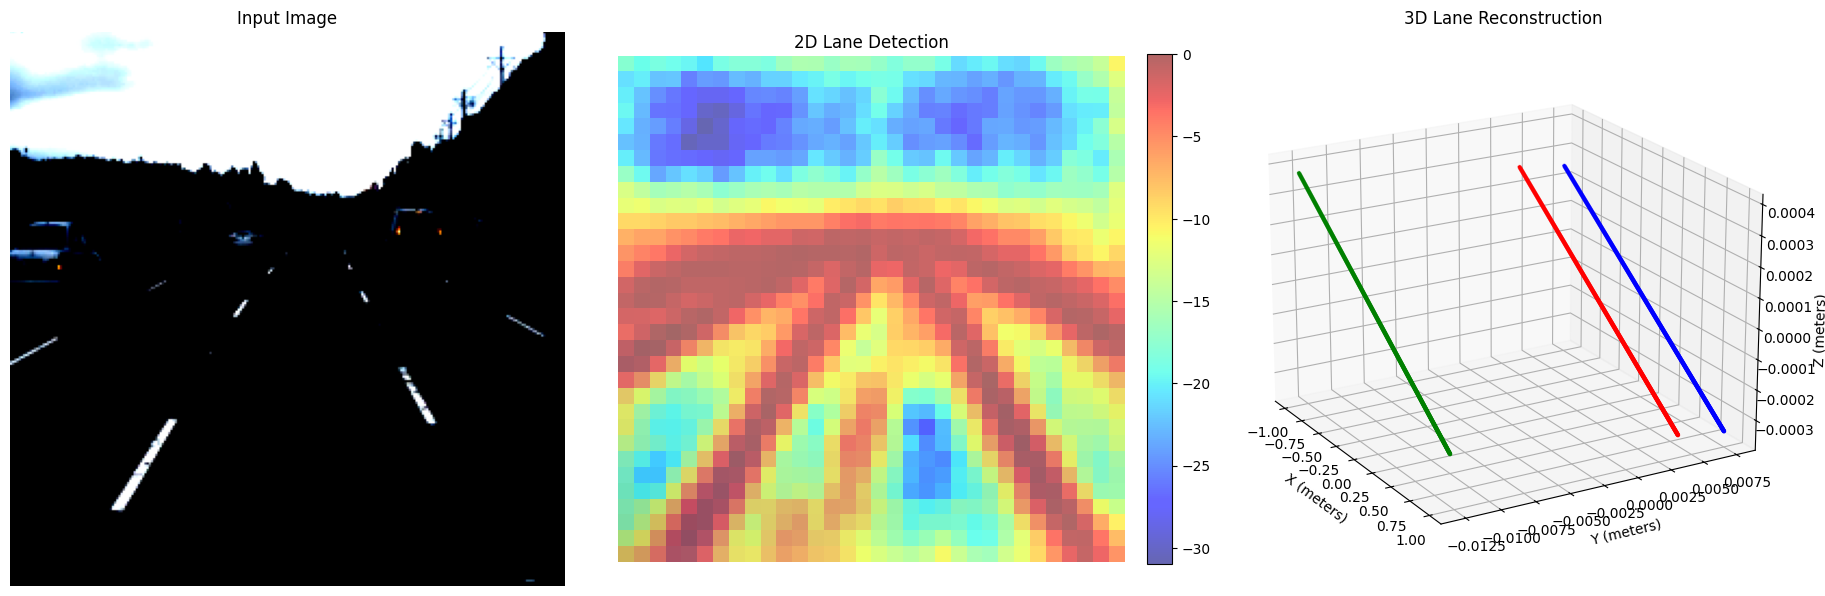

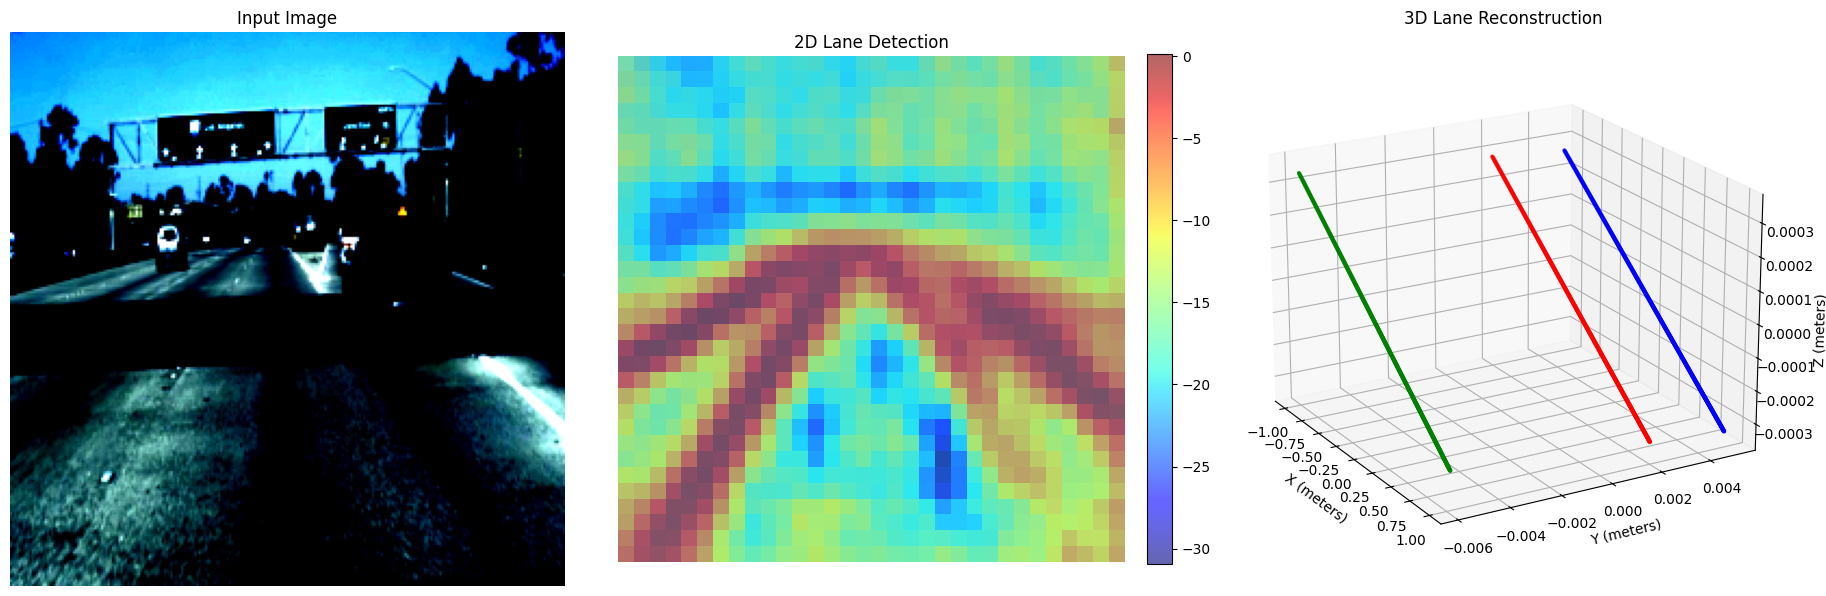

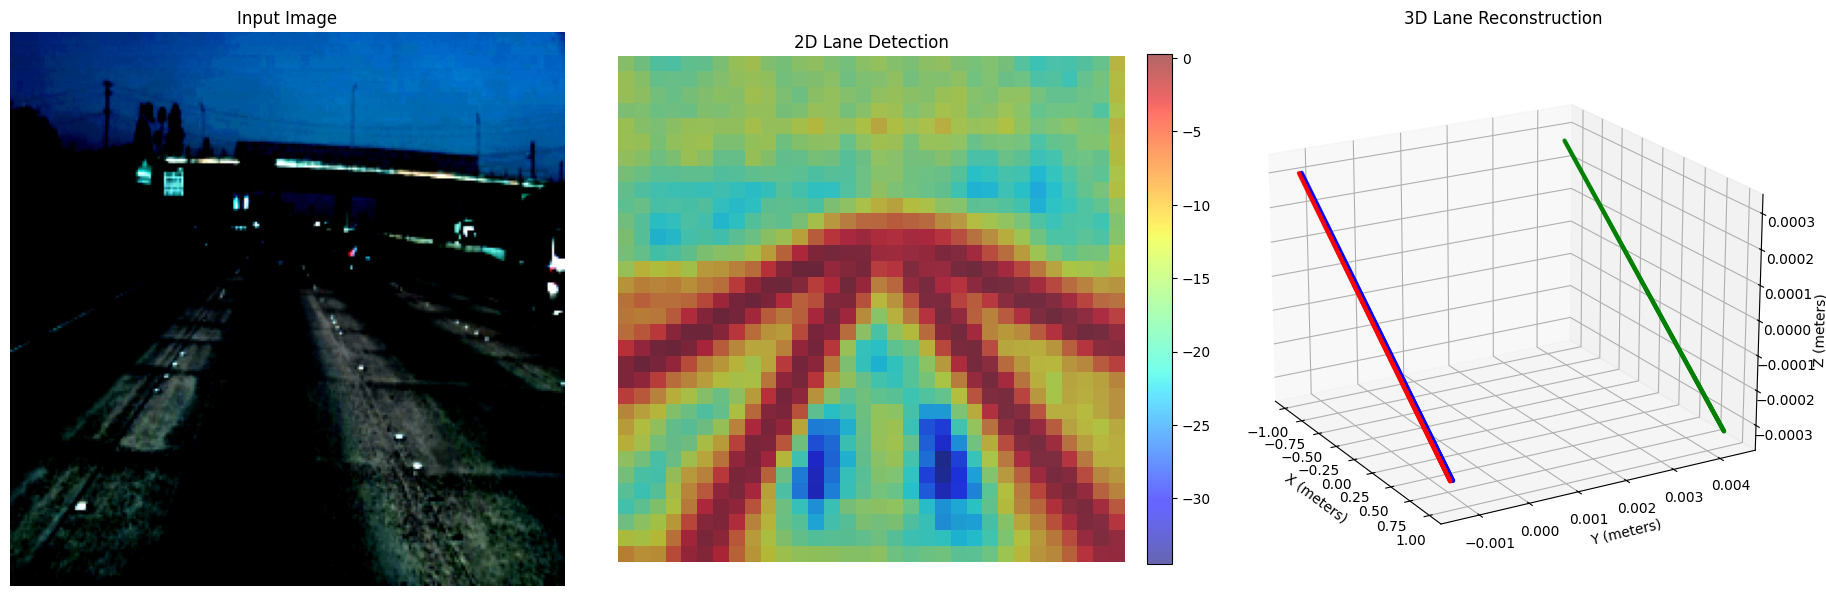

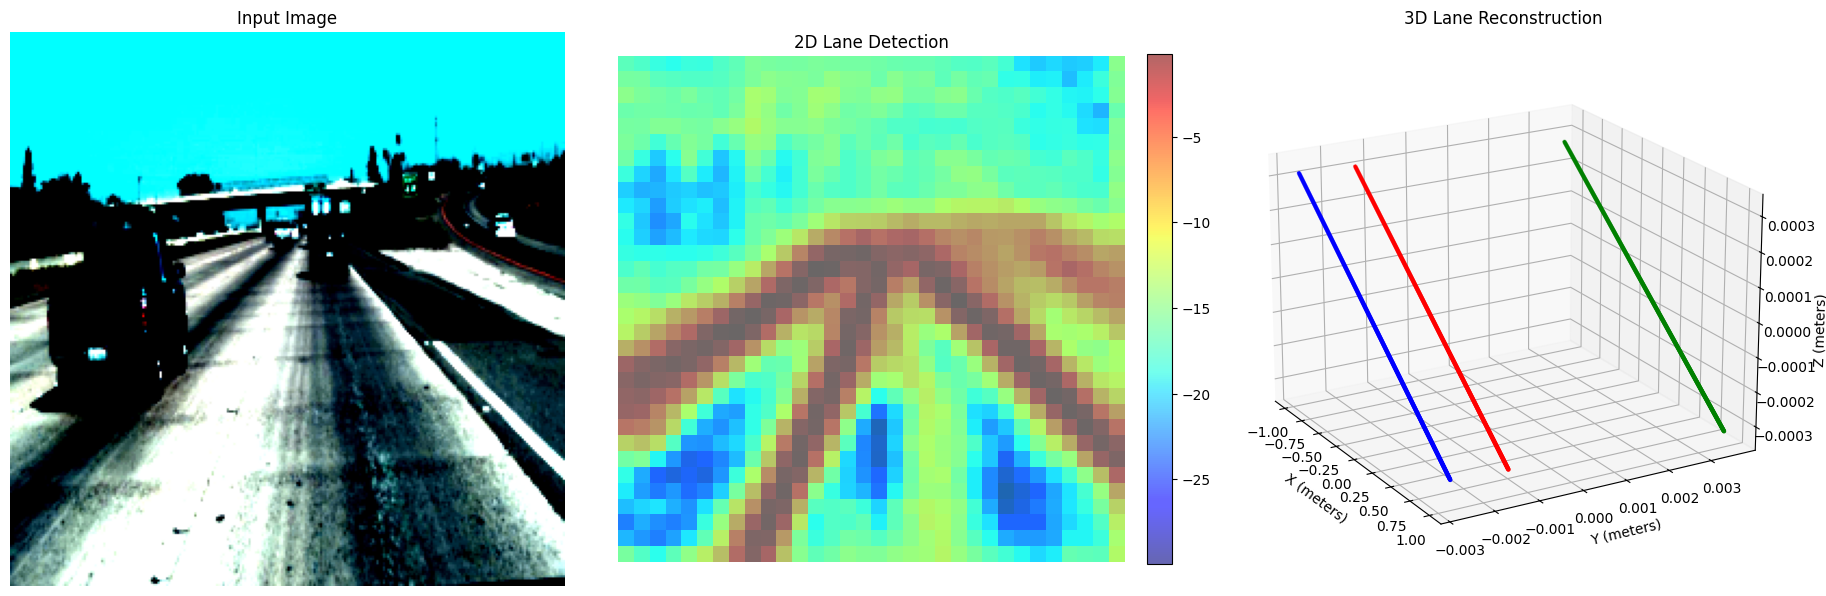

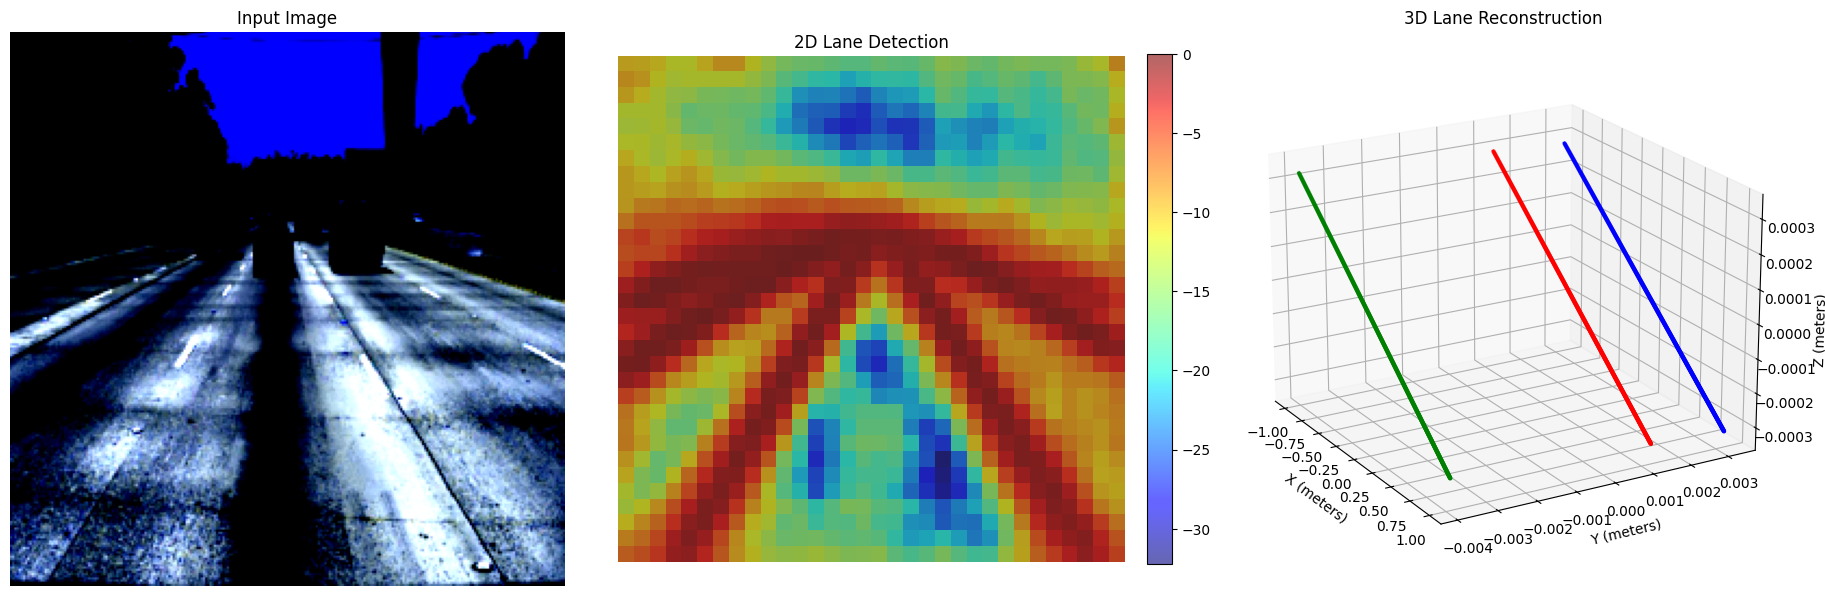

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D

def visualize_3d_lane_reconstruction(model, dataloader, device, num_samples=8):
    """
    Visualize the reconstruction of lanes from 2D to 3D.

    Args:
        model: Trained LaneDetectionModel.
        dataloader: DataLoader with validation data.
        device: Torch device (CPU or CUDA).
        num_samples: Number of samples to visualize.
    """
    model.eval()
    samples_shown = 0

    for frames, _ in dataloader:
        if samples_shown >= num_samples:
            break

        frames = frames.to(device)

        with torch.no_grad():
            lane_mask, lane_anchors, theta = model(frames)

        lane_mask_np = lane_mask.cpu().squeeze(1).numpy()
        lane_anchors_np = lane_anchors.cpu().numpy()
        theta_np = theta.cpu().numpy()

        for i in range(frames.shape[0]):
            if samples_shown >= num_samples:
                break

            frame = frames[i].cpu().permute(1, 2, 0).numpy()
            anchors_list = lane_anchors_np[i]
            theta = theta_np[i]
            heatmap = lane_mask_np[i]

            reconstructed_lanes = [reconstruct_3d_lane(anchors, theta) for anchors in anchors_list]

            # Plot results
            fig = plt.figure(figsize=(18, 6))

            # Input Image
            ax1 = fig.add_subplot(1, 3, 1)
            ax1.imshow(frame)
            ax1.set_title("Input Image")
            ax1.axis("off")

            # 2D Lane Detection
            ax2 = fig.add_subplot(1, 3, 2)
            ax2.imshow(frame, alpha=0.7)
            heatmap_overlay = ax2.imshow(heatmap, cmap="jet", alpha=0.6)
            plt.colorbar(heatmap_overlay, ax=ax2, fraction=0.046, pad=0.04)
            ax2.set_title("2D Lane Detection")
            ax2.axis("off")

            # 3D Lane Reconstruction
            ax3 = fig.add_subplot(1, 3, 3, projection='3d')
            colors = ['b', 'g', 'r', 'c', 'm', 'y']
            for idx, lane_points in enumerate(reconstructed_lanes):
                color = colors[idx % len(colors)]
                plot_3d_lane(ax3, lane_points, color=color)

            ax3.set_title("3D Lane Reconstruction")
            ax3.set_xlabel("X (meters)")
            ax3.set_ylabel("Y (meters)")
            ax3.set_zlabel("Z (meters)")
            ax3.view_init(elev=20, azim=-30)  # View adjustment for better perspective

            plt.tight_layout()
            plt.show()

            samples_shown += 1


def reconstruct_3d_lane(anchors, theta):
    """
    Reconstruct 3D lane points from lane anchors and camera pose (theta).

    Args:
        anchors: Lane anchors predicted by the model (array of shape [n]).
        theta: Camera pose angles (array of shape [3]) - [pitch, yaw, roll].

    Returns:
        3D points as a numpy array of shape (N, 3).
    """
    x = np.linspace(-1, 1, num=500)  # X-coordinates across the lane

    # Ensure anchors is iterable for np.polyval
    anchors = np.atleast_1d(anchors)

    degree = 2 if len(anchors) == 3 else 3  # Quadratic or cubic fit
    y = np.polyval(np.flip(anchors[:degree+1]), x)  # Higher-degree curve

    # Compute depth (Z) considering pitch and yaw
    pitch, yaw = theta[0], theta[1]
    z = np.tan(pitch) * x + np.tan(yaw) * y

    points_3d = np.stack([x, y, z], axis=1)
    return points_3d


def plot_3d_lane(ax, points_3d, color='b'):
    """
    Plot 3D lane points on the provided axis.

    Args:
        ax: Matplotlib 3D axis.
        points_3d: 3D points as numpy array (N, 3).
        color: Line color for the lane.
    """
    ax.plot(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c=color, linewidth=2)
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c=color, s=5)
    ax.grid(True)


# Example usage:
# Ensure model, val_loader, and device are defined
visualize_3d_lane_reconstruction(model, val_loader, device, num_samples=8)
